# Tutorial to Neural Force Field

In [1]:
import os
import sys
import numpy as np

import nff

In [5]:
import nff.train

IndentationError: unexpected indent (trainer.py, line 233)

AttributeError: module 'nff' has no attribute 'train'

# First  import data

In [2]:
# ethanol data 
train = np.load('ethanol_ccsd_t-train.npz')
xyz_data = np.dstack((np.array([train.f.z]*1000).reshape(1000, -1, 1), np.array(train.f.R)))
force_data = train.f.F
energy_data = train.f.E.squeeze() - train.f.E.mean()
smiles_data = ["COC"] * 1000

# Initialize Training and Network Parameters 

In [7]:
# initialize parameters
par = dict()
par["git_commit"] = ""
par["model_type"] = "schnet"   # model type, the other type is schnet_harmonic_bond_prior
par["n_filters"] = 256         # the filter dimensions 
par["n_gaussians"] = 32        # number of gaussian basis
par["n_atom_basis"] = 256      # dimension of atomic embeddings 
par["optim"] = 1e-4            # learning rate
par["scheduler"] = True        # use scheduler to dynamiclly change the learning rate 
par["train_percentage"] = 0.8  # percentage of data used for training 
par["T"] = 10                  # number of convolutions 
par["batch_size"] = 100        # batch size
par["cutoff"] = 5.0            # convolution radius
par["max_epoch"] = 1000        # max number of epoches training
par["trainable_gauss"] = True  # make the Gaussian parameter trainable 
par["rho"] = 0.1               # energy loss ratio
par["eps"] = 1e-5

device = 2 # which GPU to use

# Import Graph Builder and build a graph data set for training 

In [4]:
from projects.graphbuilder.graphbuilder import * 
from projects.NeuralForceField.graphs import * 

graph_data = load_graph_data(xyz_data=xyz_data, energy_data=energy_data, smiles_data=smiles_data,
                             batch_size=par["batch_size"], cutoff=par["cutoff"], 
                             force_data=force_data, au_flag=False)

Finished Batching 10 Batches


# Define Training wrappers, this steps also initializes a model and split train and test data randomly
# and start trainig for 10 epochs and look at validations 

setting up directoires for saving training files
epoch 0  U train: 6.415  force train 18.138
epoch 1  U train: 4.629  force train 13.784
epoch 2  U train: 3.528  force train 10.679
epoch 3  U train: 3.755  force train 8.738
epoch 4  U train: 1.919  force train 7.201
epoch 5  U train: 1.892  force train 6.246
epoch 6  U train: 1.522  force train 5.656
epoch 7  U train: 1.353  force train 5.164
epoch 8  U train: 1.419  force train 4.825
epoch 9  U train: 1.497  force train 4.535
forcesmae 4.340818 kcal/mol A
energiesmae 0.9674747 kcal/mol


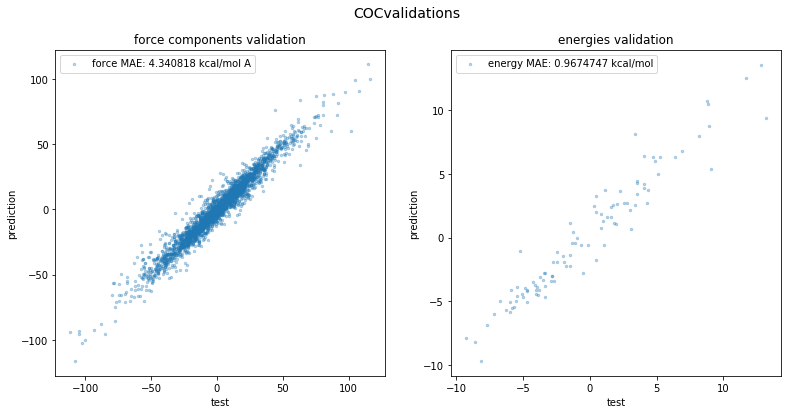

In [8]:
model = ModelPrior(par=par, graph_data=graph_data, device=device, job_name="test",
              train_flag= True, graph_batching=False, root='./log/')

# Train for 10 epochs 
model.train(10)
model.validate()

# You can validate on the entire dataset too (that includes both training and testing)

forcesmae 4.4637303 kcal/mol A
energiesmae 1.1673598 kcal/mol


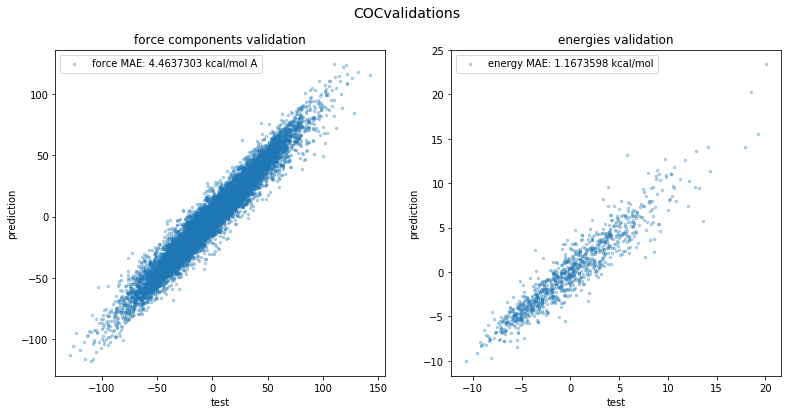

In [9]:
model.validate(graph_data)

# Run NVE simulations using the trained model

In [10]:
# import MD module 
from projects.NeuralForceField.train import *

# Initialize starting geometries 
species = "COC"
N_atom = 9 
geoms = xyz_data[0].reshape(-1, N_atom, 4) # 
xyz = geoms[:, :, 1:4] # xyz needs to have the dimension (Nbatch, Natom, 3)
r = geoms[:, :, 0] # r needs to have the dimension (Nbatch, Natom, 1)

# Here, I am not including the harmonic bond energy as prior terms, there will be a separate sections for that. 
bondAdj = None
bondlen = None

In [11]:
# MD parameters 
T = 450   # 450 K 
steps = 1000 # 1000 steps 
dt = 0.5 # femto seconds
save_frequency = 10 # save frames every 10 steps 

In [12]:
# model.model is the torch.nn.module object that is actually the model
# model is just a wrapper for training and validation.. 
traj_write = NVE(species=species, xyz=xyz, r=r, model=model.model,
               bondAdj=bondAdj, bondlen=bondlen,
               device=2,  dir_loc="./", 
               T=T, steps=steps, dt=dt, save_frequency=save_frequency)

step 0
Energy per atom: Epot = -3.786kcal/mol  Ekin = 10.458kcal/mol (T=390K)  Etot = 6.672kcal/mol
step 10
Energy per atom: Epot = -4.956kcal/mol  Ekin = 11.611kcal/mol (T=433K)  Etot = 6.655kcal/mol
step 20
Energy per atom: Epot = -2.483kcal/mol  Ekin = 9.169kcal/mol (T=342K)  Etot = 6.686kcal/mol
step 30
Energy per atom: Epot = -2.750kcal/mol  Ekin = 9.433kcal/mol (T=352K)  Etot = 6.683kcal/mol
step 40
Energy per atom: Epot = -4.562kcal/mol  Ekin = 11.239kcal/mol (T=419K)  Etot = 6.676kcal/mol
step 50
Energy per atom: Epot = -2.378kcal/mol  Ekin = 9.071kcal/mol (T=338K)  Etot = 6.693kcal/mol
step 60
Energy per atom: Epot = -5.235kcal/mol  Ekin = 11.911kcal/mol (T=444K)  Etot = 6.675kcal/mol
step 70
Energy per atom: Epot = -2.492kcal/mol  Ekin = 9.184kcal/mol (T=342K)  Etot = 6.692kcal/mol
step 80
Energy per atom: Epot = -3.032kcal/mol  Ekin = 9.712kcal/mol (T=362K)  Etot = 6.679kcal/mol
step 90
Energy per atom: Epot = -4.229kcal/mol  Ekin = 10.892kcal/mol (T=406K)  Etot = 6.663kcal/

step 820
Energy per atom: Epot = -4.409kcal/mol  Ekin = 11.093kcal/mol (T=413K)  Etot = 6.684kcal/mol
step 830
Energy per atom: Epot = -8.674kcal/mol  Ekin = 15.292kcal/mol (T=570K)  Etot = 6.618kcal/mol
step 840
Energy per atom: Epot = -4.977kcal/mol  Ekin = 11.622kcal/mol (T=433K)  Etot = 6.646kcal/mol
step 850
Energy per atom: Epot = -6.412kcal/mol  Ekin = 13.026kcal/mol (T=486K)  Etot = 6.613kcal/mol
step 860
Energy per atom: Epot = -7.655kcal/mol  Ekin = 14.276kcal/mol (T=532K)  Etot = 6.622kcal/mol
step 870
Energy per atom: Epot = -3.744kcal/mol  Ekin = 10.405kcal/mol (T=388K)  Etot = 6.661kcal/mol
step 880
Energy per atom: Epot = -8.255kcal/mol  Ekin = 14.866kcal/mol (T=554K)  Etot = 6.611kcal/mol
step 890
Energy per atom: Epot = -2.381kcal/mol  Ekin = 9.056kcal/mol (T=338K)  Etot = 6.675kcal/mol
step 900
Energy per atom: Epot = -3.692kcal/mol  Ekin = 10.344kcal/mol (T=386K)  Etot = 6.652kcal/mol
step 910
Energy per atom: Epot = -3.861kcal/mol  Ekin = 10.518kcal/mol (T=392K)  Et

In [13]:
# you can dump the movie and visualize the movies 
write_traj(filename="traj.xyz", frames=traj_write)

# Automatic  Differentiation Magic to get Forces! 

In [22]:
geoms = xyz_data[0].reshape(-1, N_atom, 4) # 
xyz = geoms[:, :, 1:4] # xyz needs to have the dimension (Nbatch, Natom, 3)
r = geoms[:, :, 0] # r needs to have the dimension (Nbatch, Natom, 1)

# send input to GPU in tensor form
r = torch.LongTensor( r.reshape(-1, N_atom) ).to(device)
xyz = torch.Tensor(xyz.reshape(-1, N_atom, 3)).to(device)
xyz.requires_grad = True

In [23]:
u = model.model(r=r, xyz=xyz, bonda=bondAdj, bondlen=bondlen)\
# compute forces
f = -compute_grad(inputs=xyz, output=u)

In [24]:
print(f) 

tensor([[[ -6.4235,  23.4385,   4.9760],
         [ 55.2682, -39.1851, -19.3042],
         [ 42.2185,   7.2071, -18.7939],
         [ -4.8881,   0.0469,  -5.3140],
         [  2.0652,   2.4802,   1.4132],
         [ -9.5111,  11.1319, -16.5280],
         [-40.8593,  21.9638,  17.3625],
         [-10.4418, -17.3723,  15.6492],
         [-27.4283,  -9.7110,  20.5391]]],
       device='cuda:2', grad_fn=<NegBackward>)


# Automatic Differentiation Magic to get Hessians!

In [25]:
from projects.NeuralForceField.tensorgrad import Neural_hess

geoms = xyz_data[0].reshape(-1, N_atom, 4) # 
xyz = geoms[:, :, 1:4] # xyz needs to have the dimension (Nbatch, Natom, 3)
r = geoms[:, :, 0] # r needs to have the dimension (Nbatch, Natom, 1)
# send input to GPU in tensor form
r = torch.LongTensor( r.reshape(-1, N_atom) ).to(device)
xyz = torch.Tensor(xyz.reshape(-1, N_atom, 3)).to(device)

hess = Neural_hess(xyz=xyz, r=r, model=model.model, device=device)
eigen = torch.eig(hess[0], eigenvectors=False, out=None)

In [26]:
print("Hessian is \n", hess)

print("Eigen Values of Hessian is \n",eigen[0])

Hessian is 
 tensor([[[1034.3430,   39.0140,  -28.2048, -362.3621, -207.2792,    3.5499,
          -376.2777,  240.6003,   16.9541,  -86.9037,  -43.3377,   36.4100,
           -88.7856,  -20.8540,  -16.4458,  -41.3182,  -28.8114,    4.7003,
           -30.2037,   -1.2179,   14.6554,  -19.4329,  -12.3387,  -26.6377,
           -29.0591,   34.2243,   -4.9816],
         [  39.0140, 1254.9666,  -13.8744, -212.6247, -300.7234,   -4.8270,
           274.2774, -295.2923,   -2.0135,  -29.5686, -336.1278,  297.6857,
            -4.6332, -294.5649, -290.0419,   19.5154,    5.2750,    9.7580,
           -36.4543,   -9.3082,   11.1684,  -55.1940,  -15.4343,  -12.9754,
             5.6680,   -8.7906,    5.1200],
         [ -28.2048,  -13.8744, 1202.3411,   -4.3471,   -9.8681, -144.8315,
            -4.2707,   12.3825,  -82.9484,   17.4172,  309.1546, -476.8026,
             4.9998, -289.2508, -518.8857,   -7.4570,    6.9977,   -3.0771,
           -23.9916,  -24.8801,    7.3402,   37.3799,   18.9808